In [16]:
# -*- coding: utf-8 -*-
# file: atae-lstm
# author: songyouwei <youwei0314@gmail.com>
# Copyright (C) 2018. All Rights Reserved.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from argparse import Namespace
import math
import os
from models import ATAE_LSTM, AOA,AEN,AEN_BERT,TargetedTransformer
from data_utils import build_tokenizer, build_embedding_matrix, ABSADataset
from tensorboardX import SummaryWriter
from sklearn import metrics
import seaborn
import matplotlib.pyplot as plt
from visualization import attention
from options import AOA_opt,AEAT_LSTM_opt,AEN_opt, AEN_BERT_opt
# from visualization.viz_utils import call_html

In [17]:
dataset_files = {
    'twitter': {
        'train': './datasets/acl-14-short-data/train.raw',
        'test': './datasets/acl-14-short-data/test.raw'
    },
    'restaurant': {
        'train': './datasets/semeval14/Restaurants_Train.xml.seg',
        'test': './datasets/semeval14/Restaurants_Test_Gold.xml.seg'
    },
    'laptop': {
        'train': './datasets/semeval14/Laptops_Train.xml.seg',
        'test': './datasets/semeval14/Laptops_Test_Gold.xml.seg'
    }
}
input_colses = {
        'atae_lstm': ['text_raw_indices', 'aspect_indices'],
        'aoa': ['text_raw_indices', 'aspect_indices'],
        'aen': ['text_raw_indices', 'aspect_indices'],
        'tt': ['text_raw_indices', 'aspect_indices'],
        'aen_bert' : ['text_raw_bert_indices', 'aspect_bert_indices']
    }
# Arguments for restaurant,AOA
initializers = {
        'xavier_uniform_': torch.nn.init.xavier_uniform_,
        'xavier_normal_': torch.nn.init.xavier_normal,
        'orthogonal_': torch.nn.init.orthogonal_,
    }
optimizers = {
        'adadelta': torch.optim.Adadelta,  # default lr=1.0
        'adagrad': torch.optim.Adagrad,  # default lr=0.01
        'adam': torch.optim.Adam,  # default lr=0.001
        'adamax': torch.optim.Adamax,  # default lr=0.002
        'asgd': torch.optim.ASGD,  # default lr=0.01
        'rmsprop': torch.optim.RMSprop,  # default lr=0.01
        'sgd': torch.optim.SGD,
    }

In [21]:
opt = Namespace(
    model_name="tt_pool_8h_8h",
    dataset='restaurant',#twitter,laptop
    seed=1234,
    optimizer = 'adam',
    initializer = 'xavier_uniform_',
    log_step = 5,
    logdir = 'log',
    embed_dim = 200,
    hidden_dim = 300,
    max_seq_len = 80,
    polarities_dim = 3,
    hops = 3,
    device = None,
    learning_rate = 0.001,
    batch_size = 128,
    l2reg = 0.0001,#0.00001
    num_epoch = 20,
    dropout = 0.1,
    inputs_cols = input_colses['tt'],
    dataset_file = dataset_files['restaurant']
)

# opt= AEN_opt
opt.model_class=TargetedTransformer
# opt.model_class= AEN
opt.device = torch.device('cpu')
opt.initializer = initializers[opt.initializer]
opt.optimizer = optimizers[opt.optimizer]
np.random.seed(opt.seed)
print(opt.dropout)

0.1


In [22]:
class Instructor:
    def __init__(self, opt):
        self.opt = opt
        tokenizer = build_tokenizer(
            fnames=[opt.dataset_file['train'], opt.dataset_file['test']],
            max_seq_len=opt.max_seq_len,
            dat_fname='{0}_tokenizer.dat'.format(opt.dataset))
        embedding_matrix = build_embedding_matrix(
            word2idx=tokenizer.word2idx,
            embed_dim=opt.embed_dim,
            em_fname='{0}_{1}_embedding_matrix.dat'.format(str(opt.embed_dim), opt.dataset),
            ev_fpath='../../../data/embeddings/glove.twitter.27B/')
        self.model = opt.model_class(embedding_matrix, opt).to(opt.device)

        trainset = ABSADataset(opt.dataset_file['train'], tokenizer)
        testset = ABSADataset(opt.dataset_file['test'], tokenizer)
 
        self.train_data_loader = DataLoader(dataset=trainset, batch_size=opt.batch_size, shuffle=True)
        self.test_data_loader = DataLoader(dataset=testset, batch_size=opt.batch_size, shuffle=False)

        if opt.device.type == 'cuda':
            print("cuda memory allocated:", torch.cuda.memory_allocated(device=opt.device.index))
        self._print_args()

    def _print_args(self):
        n_trainable_params, n_nontrainable_params = 0, 0
        for p in self.model.parameters():
            n_params = torch.prod(torch.tensor(p.shape))
            if p.requires_grad:
                n_trainable_params += n_params
            else:
                n_nontrainable_params += n_params
        print('n_trainable_params: {0}, n_nontrainable_params: {1}'.format(n_trainable_params, n_nontrainable_params))
        print('> training arguments:')
        for arg in vars(self.opt):
            print('>>> {0}: {1}'.format(arg, getattr(self.opt, arg)))

    def _reset_params(self):
        for child in self.model.children():
#             if type(child) != BertModel:  # skip bert params (with unfreezed bert)
            for p in child.parameters():
                if p.requires_grad:
                    if len(p.shape) > 1:
                        self.opt.initializer(p)
                    else:
                        stdv = 1. / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)

    def _train(self, criterion, optimizer, max_test_acc_overall=0):
        writer = SummaryWriter(log_dir=self.opt.logdir)
        max_test_acc = 0
        max_f1 = 0
        global_step = 0
        for epoch in range(self.opt.num_epoch):
            print('>' * 100)
            print('epoch: ', epoch)
            n_correct, n_total = 0, 0
            for i_batch, sample_batched in enumerate(self.train_data_loader):
                global_step += 1

                # switch model to training mode, clear gradient accumulators
                self.model.train()
                optimizer.zero_grad()

                inputs = [sample_batched[col].to(self.opt.device) for col in self.opt.inputs_cols]
                outputs = self.model(inputs)
                targets = sample_batched['polarity'].to(self.opt.device)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                if global_step % self.opt.log_step == 0:
                    n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
                    n_total += len(outputs)
                    train_acc = n_correct / n_total

                    test_acc, f1 = self._evaluate_acc_f1()
                    if test_acc > max_test_acc:
                        max_test_acc = test_acc
                        if test_acc > max_test_acc_overall:
                            if not os.path.exists('state_dict'):
                                os.mkdir('state_dict')
                            path = 'state_dict/{0}_{1}_acc{2}'.format(self.opt.model_name, self.opt.dataset, round(test_acc, 4))
                            torch.save(self.model.state_dict(), path)
                            print('>> saved: ' + path)
                    if f1 > max_f1:
                        max_f1 = f1

                    writer.add_scalar('loss', loss, global_step)
                    writer.add_scalar('acc', train_acc, global_step)
                    writer.add_scalar('test_acc', test_acc, global_step)
                    print('loss: {:.4f}, acc: {:.4f}, test_acc: {:.4f}, f1: {:.4f}'.format(loss.item(), train_acc, test_acc, f1))

        writer.close()
        return max_test_acc, max_f1

    def _evaluate_acc_f1(self):
        # switch model to evaluation mode
        self.model.eval()
        n_test_correct, n_test_total = 0, 0
        t_targets_all, t_outputs_all = None, None
        with torch.no_grad():
            for t_batch, t_sample_batched in enumerate(self.test_data_loader):
                t_inputs = [t_sample_batched[col].to(opt.device) for col in self.opt.inputs_cols]
                t_targets = t_sample_batched['polarity'].to(opt.device)
                t_outputs = self.model(t_inputs)

                n_test_correct += (torch.argmax(t_outputs, -1) == t_targets).sum().item()
                n_test_total += len(t_outputs)

                if t_targets_all is None:
                    t_targets_all = t_targets
                    t_outputs_all = t_outputs
                else:
                    t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                    t_outputs_all = torch.cat((t_outputs_all, t_outputs), dim=0)

        test_acc = n_test_correct / n_test_total
        f1 = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average='macro')
        return test_acc, f1
    def predict(self, inputs):
        outputs = None
        with torch.no_grad():
            outputs = self.model(inputs)
            
        return outputs
        
    def run(self, repeats=1):
        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = self.opt.optimizer(_params, lr=self.opt.learning_rate, weight_decay=self.opt.l2reg)

        max_test_acc_overall = 0
        max_f1_overall = 0
        for i in range(repeats):
            print('repeat: ', i)
            self._reset_params()
            max_test_acc, max_f1 = self._train(criterion, optimizer, max_test_acc_overall=max_test_acc_overall)
            print('max_test_acc: {0}     max_f1: {1}'.format(max_test_acc, max_f1))
            max_test_acc_overall = max(max_test_acc, max_test_acc_overall)
            max_f1_overall = max(max_f1, max_f1_overall)
            print('#' * 100)
        print("max_test_acc_overall:", max_test_acc_overall)
        print("max_f1_overall:", max_f1_overall)
        
    def continue_run(self, repeats=1):
        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = self.opt.optimizer(_params, lr=self.opt.learning_rate, weight_decay=self.opt.l2reg)

        max_test_acc_overall = 0
        max_f1_overall = 0
        for i in range(repeats):
            print('repeat: ', i)
            max_test_acc, max_f1 = self._train(criterion, optimizer, max_test_acc_overall=max_test_acc_overall)
            print('max_test_acc: {0}     max_f1: {1}'.format(max_test_acc, max_f1))
            max_test_acc_overall = max(max_test_acc, max_test_acc_overall)
            max_f1_overall = max(max_f1, max_f1_overall)
            print('#' * 100)
        print("max_test_acc_overall:", max_test_acc_overall)
        print("max_f1_overall:", max_f1_overall)

In [23]:
ins = Instructor(opt)
ins.model

loading tokenizer: restaurant_tokenizer.dat
loading embedding_matrix: 200_restaurant_embedding_matrix.dat
n_trainable_params: 2081087, n_nontrainable_params: 917000
> training arguments:
>>> model_name: tt_pool_8h_8h
>>> dataset: restaurant
>>> seed: 1234
>>> optimizer: <class 'torch.optim.adam.Adam'>
>>> initializer: <function xavier_uniform_ at 0x000002856E2481E0>
>>> log_step: 5
>>> logdir: log
>>> embed_dim: 200
>>> hidden_dim: 300
>>> max_seq_len: 80
>>> polarities_dim: 3
>>> hops: 3
>>> device: cpu
>>> learning_rate: 0.001
>>> batch_size: 128
>>> l2reg: 0.0001
>>> num_epoch: 20
>>> dropout: 0.1
>>> inputs_cols: ['text_raw_indices', 'aspect_indices']
>>> dataset_file: {'train': './datasets/semeval14/Restaurants_Train.xml.seg', 'test': './datasets/semeval14/Restaurants_Test_Gold.xml.seg'}
>>> model_class: <class 'models.tt.TargetedTransformer'>


TargetedTransformer(
  (embed): Embedding(4585, 200)
  (squeeze_embedding): SqueezeEmbedding()
  (attn_text): Attention(
    (w_k): Linear(in_features=200, out_features=200, bias=True)
    (w_q): Linear(in_features=200, out_features=200, bias=True)
    (proj): Linear(in_features=200, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (attn_text2): Attention(
    (w_k): Linear(in_features=300, out_features=296, bias=True)
    (w_q): Linear(in_features=300, out_features=296, bias=True)
    (proj): Linear(in_features=296, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (attn_aspect): Attention(
    (w_k): Linear(in_features=200, out_features=200, bias=True)
    (w_q): Linear(in_features=200, out_features=200, bias=True)
    (proj): Linear(in_features=200, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (ffn_c): PositionwiseFeedForward(
    (w_1): Conv1d(300, 300, kernel_size=(1,), stride=(1,))
    (w_2): Conv1d(300, 300, kernel_size=(1,), st

In [ ]:

ins.run(5)

repeat:  0
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
epoch:  0
>> saved: state_dict/tt_pool_8h_8h_restaurant_acc0.583
loss: 1.1134, acc: 0.2734, test_acc: 0.5830, f1: 0.2801
>> saved: state_dict/tt_pool_8h_8h_restaurant_acc0.65
loss: 0.9870, acc: 0.4258, test_acc: 0.6500, f1: 0.2626
loss: 1.1598, acc: 0.3594, test_acc: 0.2223, f1: 0.1551
loss: 0.9557, acc: 0.4199, test_acc: 0.5295, f1: 0.2896
loss: 1.0912, acc: 0.4562, test_acc: 0.6500, f1: 0.2626
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
epoch:  1
loss: 0.9710, acc: 0.6094, test_acc: 0.3402, f1: 0.2434
loss: 0.9805, acc: 0.5898, test_acc: 0.3304, f1: 0.2632
loss: 1.0138, acc: 0.5573, test_acc: 0.5527, f1: 0.3896
loss: 1.0044, acc: 0.5508, test_acc: 0.6196, f1: 0.2787
loss: 0.9791, acc: 0.5641, test_acc: 0.6500, f1: 0.2626
>> saved: state_dict/tt_pool_8h_8h_restaurant_acc0.6705
loss: 0.9851, acc: 0.5677, test_acc: 0.670

In [ ]:
ins.model.load_state_dict(torch.load('./state_dict/tt_pool_restaurant_acc0.767'))
ins.continue_run()

In [9]:
ins.model

TargetedTransformer(
  (embed): Embedding(4585, 200)
  (squeeze_embedding): SqueezeEmbedding()
  (attn_text): Attention(
    (w_k): Linear(in_features=200, out_features=200, bias=True)
    (w_q): Linear(in_features=200, out_features=200, bias=True)
    (proj): Linear(in_features=200, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (attn_text2): Attention(
    (w_k): Linear(in_features=300, out_features=296, bias=True)
    (w_q): Linear(in_features=300, out_features=296, bias=True)
    (proj): Linear(in_features=296, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (attn_aspect): Attention(
    (w_k): Linear(in_features=200, out_features=200, bias=True)
    (w_q): Linear(in_features=200, out_features=200, bias=True)
    (proj): Linear(in_features=200, out_features=300, bias=True)
    (dropout): Dropout(p=0.1)
  )
  (ffn_c): PositionwiseFeedForward(
    (w_1): Conv1d(300, 300, kernel_size=(1,), stride=(1,))
    (w_2): Conv1d(300, 300, kernel_size=(1,), st

In [7]:
# ins.model.load_state_dict(torch.load('./state_dict/atae_lstm_restaurant_acc0.7804'))
# ins.model

In [ ]:
# ins.model.load_state_dict(torch.load('./state_dict/aoa_restaurant_acc0.7893')) 
# ins.model

In [8]:
tokenizer = build_tokenizer(
            fnames=[opt.dataset_file['train'], opt.dataset_file['test']],
            max_seq_len=opt.max_seq_len,
            dat_fname='{0}_tokenizer.dat'.format(opt.dataset))
opt.dataset_file['test']
testset = ABSADataset(opt.dataset_file['test'],tokenizer)
       
test_data_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)



loading tokenizer: restaurant_tokenizer.dat


In [9]:
fin = open(opt.dataset_file['test'], 'r', encoding='utf-8', newline='\n', errors='ignore')
lines = fin.readlines()        

In [10]:
tokenizer.get_ctx_words(lines[84])
# lines[85].split()
testset[28]['text_raw_indices']

array([   2,  980,   29,    2,   17,  228,  792,  120,   59, 2086,    9,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int64)

In [11]:
testset[28]

{'text_bert_indices': array([4584,    2,  980,   29,    2,   17,  228,  792,  120,   59, 2086,
           9, 4584,  980,   29,    2,   17,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int64),
 'bert_segments_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 'text_raw_indices': array([   2,  980,   29,    2,   17,  228,  792,  120,   59, 2086,    9,
           0,    0

# index : 28 , apsect_count:4

In [11]:
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)

In [12]:

def draw_attention(index_list):
    fig, axs = plt.subplots(1,len(index_list), figsize=(20, 10))
    for i,index in enumerate(index_list):
         # inputs = [torch.from_numpy(testset[0]['text_raw_indices']).view(1,80),torch.from_numpy(testset[0]['aspect_indices']).view(1,80)]
        inputs = [torch.from_numpy(testset[index]['text_raw_indices']).view(1,80),torch.from_numpy(testset[index]['aspect_indices']).view(1,80)]
        ins.model(inputs)
        atts = ins.model.align_mat.detach().numpy()
        col_align = ins.model.col_align.detach().numpy()
        row_align = ins.model.row_align.detach().numpy()

        # draw(row_align[0], lines[1].split(),tokenizer.get_ctx_words(lines[0]),axs[0])
        draw(col_align[0], lines[index*3+1].split(),lines[index*3].replace('$T$',lines[index*3+1]).split(),axs[i])
    plt.show()

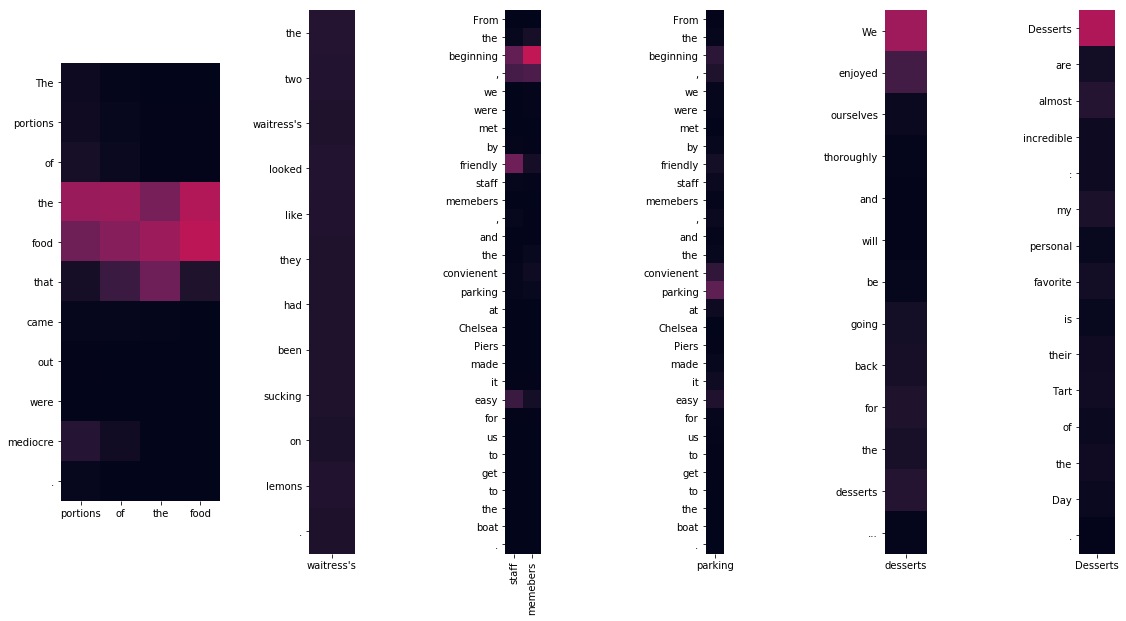

In [13]:
draw_attention([28,29,30,31,32,33])